In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud , STOPWORDS
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score , confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

**Loading the Dataset**

In [ ]:

data = pd.read_csv('amazon.csv')
data.head()

,Unnamed: 0,reviewerName,Unnamed: 2,text,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,Unnamed: 12,score
0,0,NaN,NaN,No issues.,23-07-2014,138,0,0,0,0,0.0,0.0,NaN,4
1,1,0mie,NaN,"Purchased this for my device, it worked as adv...",25-10-2013,409,0,0,0,0,0.0,0.0,NaN,5
2,2,1K3,NaN,it works as expected. I should have sprung for...,23-12-2012,715,0,0,0,0,0.0,0.0,NaN,4
3,3,1m2,NaN,This think has worked out great.Had a diff. br...,21-11-2013,382,0,0,0,0,0.0,0.0,NaN,5
4,4,2&amp;1/2Men,NaN,"Bought it with Retail Packaging, arrived legit...",13-07-2013,513,0,0,0,0,0.0,0.0,NaN,5


 **Number of rows and Columns :**

In [ ]:
data.shape


(4915, 14)

In [ ]:
data.columns

Index(['Unnamed: 0', 'reviewerName', 'Unnamed: 2', 'text', 'reviewTime',
       'day_diff', 'helpful_yes', 'helpful_no', 'total_vote',
       'score_pos_neg_diff', 'score_average_rating', 'wilson_lower_bound',
       'Unnamed: 12', 'score'],
      dtype='object')

**Selecting the ReviewText and Overall rating Columns**

In [ ]:
data1= data[['text','score']]
data1.head()

,text,score
0,No issues.,4
1,"Purchased this for my device, it worked as adv...",5
2,it works as expected. I should have sprung for...,4
3,This think has worked out great.Had a diff. br...,5
4,"Bought it with Retail Packaging, arrived legit...",5


**Count of Each Rating/Score**

In [ ]:
data1.score.value_counts()

5    3922
4     527
1     244
3     142
2      80
Name: score, dtype: int64

<Axes: >

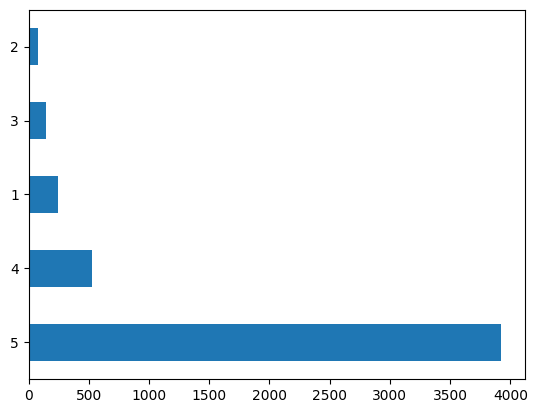

In [ ]:
data1.score.value_counts().plot(kind = 'barh')

In [ ]:
data1.isnull().sum()

text     0
score    0
dtype: int64

In [ ]:
def map_review(x):
  if x<3:
    return 'Negative'
  elif x==3:
    return 'Neutral'
  else:
    return 'Positive'

In [ ]:
data1['Review'] = data1['score'].apply(lambda x: map_review(x))

<ipython-input-89-4b83e9a51457>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Review'] = data1['score'].apply(lambda x: map_review(x))


In [ ]:
data1.head()

,text,score,Review
0,No issues.,4,Positive
1,"Purchased this for my device, it worked as adv...",5,Positive
2,it works as expected. I should have sprung for...,4,Positive
3,This think has worked out great.Had a diff. br...,5,Positive
4,"Bought it with Retail Packaging, arrived legit...",5,Positive


In [ ]:
!pip install stop_words

In [ ]:
import nltk
from stop_words import get_stop_words
stopwords = get_stop_words('english')

In [ ]:
#Stopwords
total_stopwords = set(stopwords)

# subtract negative stop words like no , not , don't etc.. from total _stopwords
negative_stop_words = set(word for word in total_stopwords
                          if "n't" in word or 'no' in word)
final_stopwords= total_stopwords - negative_stop_words
final_stopwords.add("one")
print(final_stopwords)

{'most', 'been', 'or', 'why', 'your', 'doing', 'a', 'that', "i've", "what's", "they're", 'same', "how's", 'all', 'has', 'so', "you'd", 'theirs', "we're", 'after', 'of', 'in', "we'd", "he'd", 'very', 'does', 'and', 'further', 'her', 'there', "there's", "here's", 'do', "you're", "she's", 'could', 'themselves', 'for', 'it', 'having', 'yours', 'into', 'each', 'these', 'until', 'who', 'would', 'were', 'an', 'herself', 'on', "they'd", 'out', "where's", "you've", 'once', "she'll", 'is', 'they', 'ours', 'too', "they've", 'the', 'above', 'while', 'below', 'their', 'this', 'during', 'any', "i'll", "let's", 'only', 'be', 'should', 'under', "you'll", 'as', 'here', 'against', "i'm", 'such', 'again', 'myself', 'me', 'from', "he'll", "that's", "we'll", 'than', 'we', 'because', 'own', 'off', "she'd", 'being', 'before', 'did', 'yourself', 'both', 'over', 'its', 'through', "he's", 'about', 'up', 'itself', 'between', 'had', 'down', "they'll", "we've", 'his', 'what', 'where', 'which', "it's", 'she', 'how'

In [ ]:
#stemming object
stemmer = PorterStemmer()
HTMLTAGS = re.compile('<.*?>')
table = str.maketrans(dict.fromkeys(string.punctuation))
remove_digits = str.maketrans('','',string.digits)
MULTIPLE_WHITESPACE = re.compile(r"\s+")

In [ ]:
def Text_preprocessor(review):

  review = HTMLTAGS.sub(r'',review)

  review = review.translate(table)

  review = review.translate(remove_digits)

  review = review.lower()
  review = MULTIPLE_WHITESPACE.sub(" ",review).strip()

  review = [word for word in review.split()
            if word not in final_stopwords]

  review = ' '.join([stemmer.stem(word) for word in review])

  return review



In [ ]:
text = 'in my galaxy s4, super fast card, and am totally happy, not happy having to still type to fill the required words though'

In [ ]:
Text_preprocessor(text)

'galaxi s super fast card total happi not happi still type fill requir word though'

**WordCloud**

In [ ]:
def generate_wcloud(text):
  stopwords = set(STOPWORDS)
  wordcloud = WordCloud(stopwords=stopwords , background_color='white')
  wordcloud.generate(text)
  plt.figure(figsize=(15,7))
  plt.axis('off')
  plt.imshow(wordcloud)
  return plt.show()

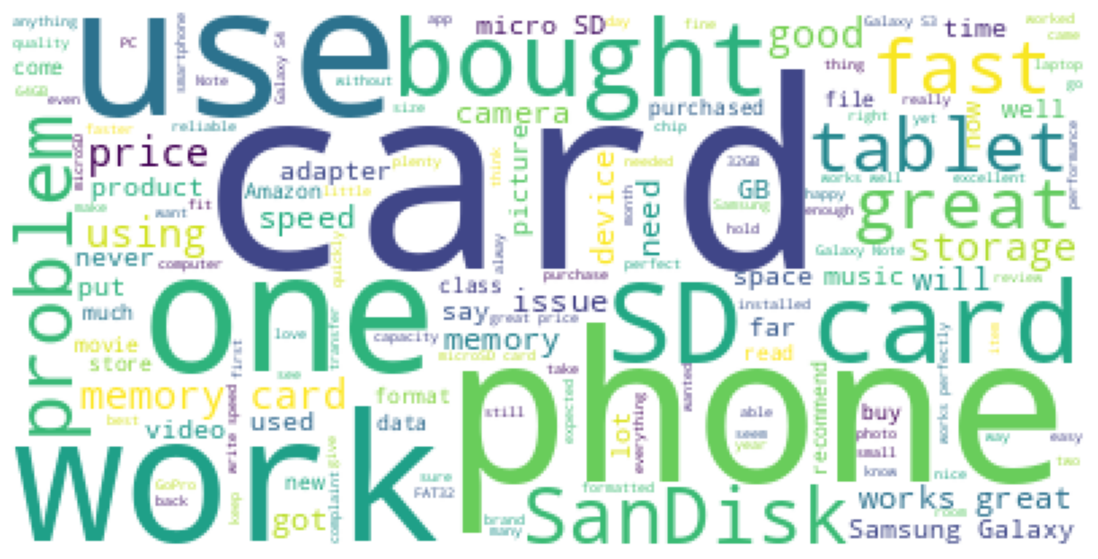

In [ ]:
pos = data1.loc[data1.Review == "Positive"].text
Text = " ".join(review for review in pos.astype(str))

generate_wcloud(Text)

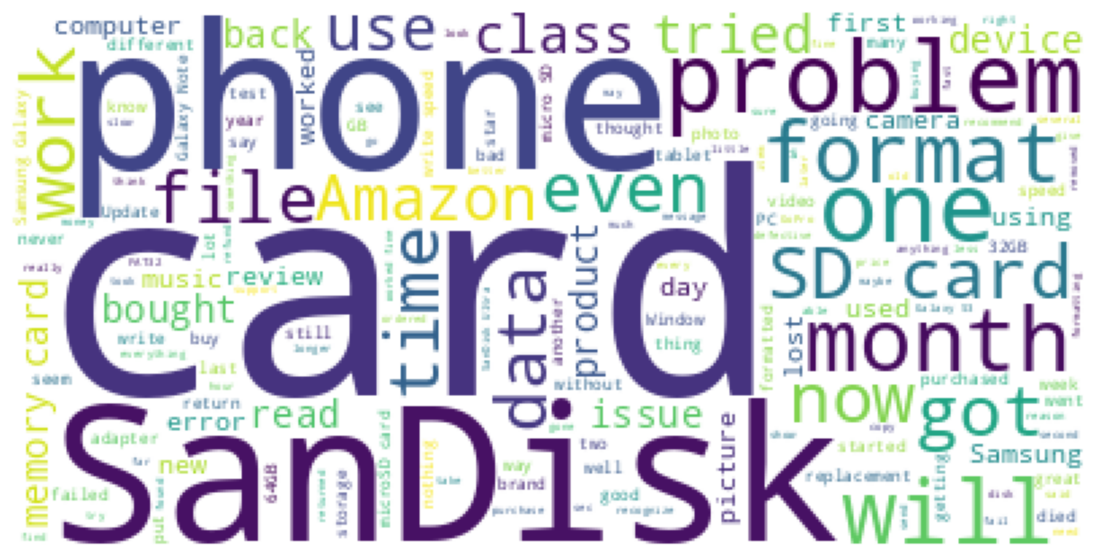

In [ ]:

Neg = data1.loc[data1.Review=="Negative"].text
Text = " ".join(review for review in Neg.astype(str))
generate_wcloud(Text)


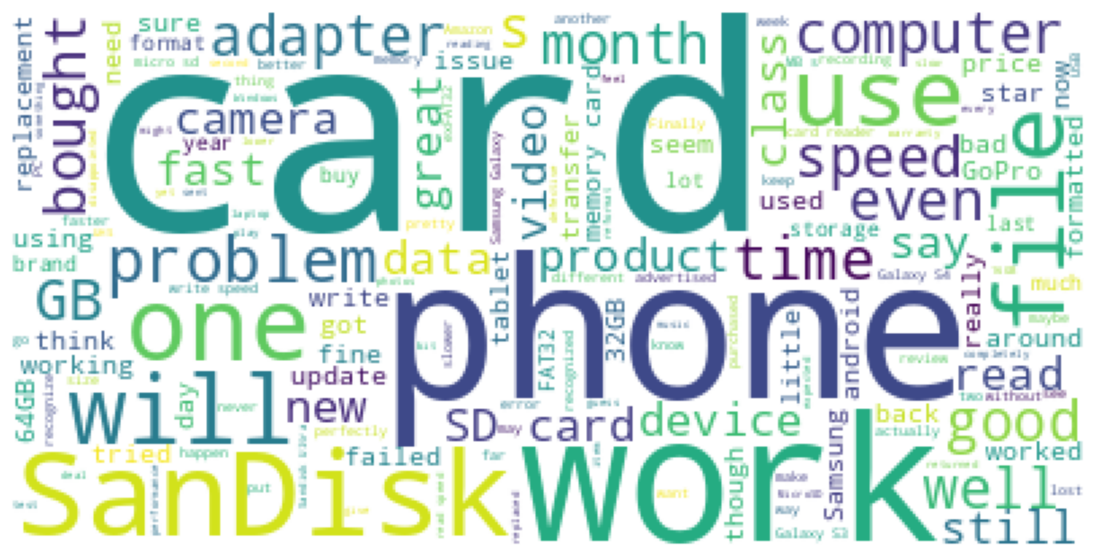

In [ ]:
Neut = data1.loc[data1.Review == "Neutral"].text
Text = " ".join(review for review in Neut.astype(str))
generate_wcloud(Text)

In [ ]:
x= data1.text
y=data1.Review

X_train , X_test , y_train , y_test = train_test_split(x,y,test_size = 0.20, random_state=1 , stratify=y)

In [ ]:
X_train.shape , X_test.shape

((3932,), (983,))

**CountVectorizer**

In [ ]:
bow_vectorizer = CountVectorizer(max_features=10000)
bow_vectorizer.fit(X_train)

bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)

**TfidfVectorizer**

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)
# transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)

Label Encoder

In [ ]:
labelEncoder = LabelEncoder()
y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

labels = labelEncoder.classes_.tolist()
print(labels)

['Negative', 'Neutral', 'Positive']


In [ ]:
def train_and_eval(model, trainX, trainY , testX, testY):
  model.fit(trainX, trainY)

  y_preds_train = model.predict(trainX)
  y_preds_test = model.predict(testX)

  # evaluation
  print()
  print(model)
  print(f"Train accuracy score : {accuracy_score(y_train,y_preds_train)}")
  print(f"Test accuracy score : {accuracy_score(y_test , y_preds_test)}")
  print('\n',40*'-')

In [ ]:
C=[0.001,0.01,0.1,1,10]
for c in C:
  log_model  = LogisticRegression(C=c , max_iter =500 , random_state=1)

  train_and_eval(model=log_model,trainX=bow_X_train, trainY = y_train, testX=bow_X_test, testY = y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.9104781281790437
Test accuracy score : 0.9023397761953205

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.9323499491353001
Test accuracy score : 0.9125127161749745

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.9720244150559512
Test accuracy score : 0.9196337741607324

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.9984740590030519
Test accuracy score : 0.9216683621566633

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 1.0
Test accuracy score : 0.9165818921668362

 ----------------------------------------


In [ ]:
alphas = [0,0.2,0.6,0.8,1]

for a in alphas:
  #define model
  nb_model = MultinomialNB(alpha=a)
  train_and_eval(model=nb_model,trainX=bow_X_train,trainY=y_train,testX=bow_X_test,testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.9898270600203459
Test accuracy score : 0.9043743641912513

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.9720244150559512
Test accuracy score : 0.9165818921668362

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.95676500508647
Test accuracy score : 0.9226856561546287

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.9549847405900305
Test accuracy score : 0.9237029501525941

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.9514242115971516
Test accuracy score : 0.9216683621566633

 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


In [ ]:
C = [0.001,0.01,0.1,1,10]
for c in C:
  #define model
  log_model = LogisticRegression(C=c, max_iter=500,random_state=1)
  # Train and evaluate model
  train_and_eval(model=log_model,trainX=bow_X_train,trainY=y_train,testX=bow_X_test,testY=y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.9104781281790437
Test accuracy score : 0.9023397761953205

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.9323499491353001
Test accuracy score : 0.9125127161749745

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.9720244150559512
Test accuracy score : 0.9196337741607324

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.9984740590030519
Test accuracy score : 0.9216683621566633

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 1.0
Test accuracy score : 0.9165818921668362

 ----------------------------------------


**Best model : Logistic Regression(c=1) with Tfidf data**

In [ ]:
bmodel = LogisticRegression(C=1,max_iter=500,random_state=1)
bmodel.fit(tfidf_X_train,y_train)

LogisticRegression(C=1, max_iter=500, random_state=1)

In [ ]:
#predictions
y_preds_train = bmodel.predict(tfidf_X_train)
y_preds_test = bmodel.predict(tfidf_X_test)

In [ ]:
print(f"Train accuracy score : {accuracy_score(y_train,y_preds_train)}")
print(f"Test accuracy score : {accuracy_score(y_test,y_preds_test)}")

Train accuracy score : 0.939471007121058
Test accuracy score : 0.9206510681586979


In [ ]:
def plot_cm(y_true,y_pred):
  plt.figure(figsize=(6,6))
  cm=confusion_matrix(y_true,y_pred, normalize = 'true')
  sns.heatmap(
      cm, annot=True , cmap='Blues', cbar=False , fmt='.2f' ,
      xticklabels = labels , yticklabels = labels
  )
  return plt.show()

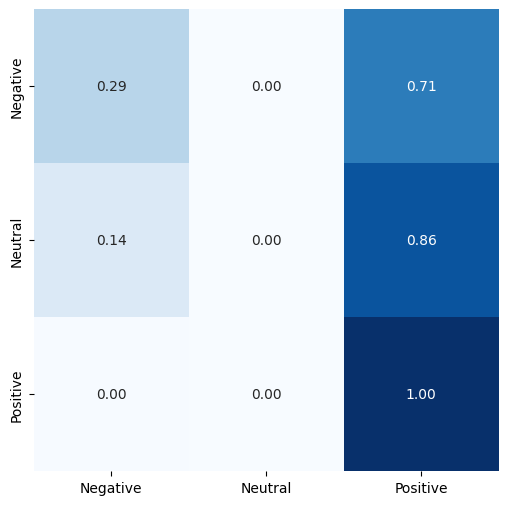

In [ ]:
plot_cm(y_test, y_preds_test)

**Prediction on single review**

In [ ]:
def get_sentiment(review):
  x=Text_preprocessor(review)
  x=tfidf_vectorizer.transform([x])
  y=int(bmodel.predict(x.reshape(1,-1)))
  return labels[y]

In [ ]:
# positive review
review = "Heard that the card's write speed is insufficient, however I have used it extensively and haven't had a single problem with it!!"
print(f"This is a {get_sentiment(review)} review!")

This is a Positive review!


<ipython-input-120-104fed5a5fca>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y=int(bmodel.predict(x.reshape(1,-1)))


In [ ]:
#Negative review
review = " not satisfied with the card"
print(f"This is a {get_sentiment(review)} review! ")